# Exploring Catalog-based Evaluations

Author: William Savran  
Date: 05 May 2020

The catalog-based evaluations outlined in Savran et al., 2020 provide likelihood-free counterparts to the Poisson-based evaluations designed for gridded forecasts (e.g., Schorlemmer et al., 2007; Zechar et al., 2010). In this notebook, I investigate the behavior of these likelihood-free evaluations in the context of their Poissonian counterparts. This analysis will help to illuminate the differences between these approaches, and potentially identify short-comings of the new evaluations.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle raw code"></form>''')



## Introduction

The following numerical experiments use simulations on spatially uniform (SU) forecasts to explore the behavior of the statistics proposed in Savran et al., 2020. The equation for the test statistic is as follows,

\begin{equation}
S = \left [ \sum_{i=1}^{N} \log{\hat{\lambda}(k_i)} \right ] N^{-1}.
\end{equation}

Here $\hat{\lambda}$ is the approximate rate-density provided estimated as the expected event-count per spatial cell from the forecast and $N$ represents the number of target events, and $k_i$ indicates the cell index, $k$, of the $i^{th}$ event. The statistic $S$ can be regarded as the geometric mean of the target event rate distribution.

In additon to the SU forecasts, I use two forecasts from UCERF3-ETAS and UCERF3-NoFaults starting after the M 7.1 Ridgecrest mainshock to explore the catalog-based spatial-test. These forecasts are located on `opensha [dot] usc [dot] edu` at the path defined in the code cell below. The analysis uses the PyCSEP toolkit available on [GitHub](https://github.com/SCECcode/csep2/).

In [2]:
# Python Imports
import itertools

# Third-party Imports
import numpy as np
import matplotlib.pyplot as plt

# PyCSEP imports
from csep.core.forecasts import GriddedDataSet
from csep.core.evaluations import EvaluationResult
from csep.utils.spatial import CartesianGrid2D
from csep.utils.stats import ecdf
from csep.core.csep1_tests import csep1_spatial_test

In [3]:
# path to directory where simulations are stored
u3etas_dir = '/home/scec-02/kmilner/ucerf3/etas_sim/2019_09_04-ComCatM7p1_ci38457511_ShakeMapSurfaces'
u3nofauls_dir = '/home/scec-00/wsavran/working/ucerf3-ridgecrest/2019_09_04-ComCatM7p1_ci38457511_ShakeMapSurfaces-NoFaults'

# path to catalog file used for manuscript
catalog_file = '/home/scec-01/wsavran/comcat_repo/2019-11-11-comcat.json'

# random seed for reproducibility
seed=1234567
np.random.seed(seed)

In [4]:
class MockCatalog:
    """ Creates a mock object that can be used to call csep1_tests directly. """
    def __init__(self, data, name=''):
        self.data = data
        self.name = name
        
    def spatial_counts(self):
        return self.data

def create_uniform_spatial_forecast(constant_rate, region, name=''):
    """ Create uniform spatial forecast for evaluation purposes
    
    Args:
        constant_rate (float): value of homogeneous poisson point-process
        region (csep.utils.spatial.Region): region of uniform forecast
        name (str): used to label the forecast for plotting 
        
    Returns:
        forecast (csep.core.forecasts.GriddedDataSet): spatial forecast
    """
    # this will throw error if it cannot be made into numpy array
    rate = np.array(constant_rate)
    if not isinstance(region, CartesianGrid2D):
        raise TypeError("region should be CartesianGrid2D")
    
    # this will throw and error if constant_rate is not a scalar or list-like with 
    data = np.ones(region.num_nodes) * constant_rate
    spatial_forecast = GriddedDataSet(data, region, name)
    return spatial_forecast

def simulate_catalog(forecast, n_target_events, force_unity=False):
    n_bins = forecast.region.num_nodes
    obs_cat = np.zeros(n_bins)
    rand_event_locs = np.random.randint(n_bins, size=int(n_target_events))
    if force_unity:
        rand_event_locs = list(set(rand_event_locs))
    np.add.at(obs_cat, rand_event_locs, 1)
    cat = MockCatalog(obs_cat)
    return cat

def spatial_test_statistic_no_normalization(gridded_forecast_rates, target_counts):
    """ implemented following Eq. 18 in BSSA manuscript"""
    n_target = np.sum(target_counts)
    log_rates = np.log10(gridded_forecast_rates)
    # we still compute the mean here
    statistic = np.sum(target_counts*log_rates) / n_target
    return statistic
    
def spatial_test_statistic_normalization(gridded_forecast_rates, target_counts):
    """ implemented following Eq. 18 in BSSA manuscript"""
    n_target = np.sum(target_counts)
    # normalize so rates sum to unity
    normed_rates = gridded_forecast_rates / np.sum(gridded_forecast_rates)
    log_rates = np.log10(normed_rates)
    # we still compute the mean here
    statistic = np.sum(target_counts*log_rates) / n_target
    return statistic

def approximate_likelihood_statistic_normalization(gridded_forecast_rates, target_counts):
    """ implemented following Eq. 18 in BSSA manuscript"""
    n_target = np.sum(target_counts)
    # normalize so rates sum to unity
    normed_rates = gridded_forecast_rates / np.sum(gridded_forecast_rates)
    log_rates = np.log10(normed_rates)
    # we still compute the mean here
    statistic = np.sum(target_counts*log_rates)
    return statistic

def csep2_spatial_test(forecast, observed_catalog, num_simulations=10000, fix_simulated_events=True,
                       func=spatial_test_statistic_normalization):
    """
    Performs the Spatial Test on the Forecast using the Observed Catalogs.

    Note: The forecast and the observations should be scaled to the same time period before calling this function. This increases
    transparency as no assumptions are being made about the length of the forecasts. This is particularly important for
    gridded forecasts that supply their forecasts as rates.

    Args:
        gridded_forecast: csep.core.forecasts.GriddedForecast
        observed_catalog: csep.core.catalogs.Catalog
        num_simulations (int): number of simulations used to compute the quantile score
        fix_simulated_events (bool): whether we should condition on the number of simualted events

    Returns:
        evaluation_result: csep.core.evaluations.EvaluationResult
    """
    # grid catalog onto spatial grid
    gridded_catalog_data = observed_catalog.spatial_counts()
    n_obs = np.sum(gridded_catalog_data)
    n_fore = np.sum(forecast.spatial_counts())
    
    test_distribution = np.empty(num_simulations)
    for idx in range(num_simulations):
        # determine number of events to simulate, inject ETAS event counts here. maybe?
        if fix_simulated_events == True:
            n_sim = n_obs
        else:
            n_sim = int(np.random.poisson(n_fore))
        # simulate target catalog
        target_catalog = simulate_catalog(forecast, n_sim)
        # add to test distribution
        test_distribution[idx] = func(forecast.spatial_counts(), target_catalog.data)
        
    observed_statistic = func(forecast.spatial_counts(), gridded_catalog_data)
    
    qs = np.sum(test_distribution <= observed_statistic) / num_simulations

    # populate result data structure
    result = EvaluationResult()
    result.test_distribution = test_distribution
    result.name = 'S-Test'
    result.observed_statistic = observed_statistic
    result.quantile = qs
    result.sim_name = forecast.name
    result.obs_name = f'N-obs: {n_obs}'
    result.status = 'normal'
    result.min_mw = None

    return result

## Understanding the Spatial Test using Spatially Uniform Forecasts

**Summary:**
1. Normalizing $\lambda$ only becomes important if one is interested in comparing observed statistics between two forecasts. Without normalization the statistic differs by $\log(K)$ where $K$ is the ratio of expected event counts between the two forecasts.<br>

2. For SU forecasts, the test distribution of $S$ is, by definition, not influenced by variability in the forecasted number distribution. 

3. Implied, but not confirmed from the SU tests: The error in the estimate of $S$ will be influenced by the both sampling distribution and the distribution of $\hat{\lambda}$. The former is how we are probing the 'spatial distribution' of the forecast.

3. The CSEP1 metric has non-zero variance in the test-distribution even when the observed catalog is generated from the same distribution as the forecast. This results from multiple events occurring in a spatial bin. 

4. The geometric mean and the sum of the target event rate distribution (spatial Pseudo-LL) produce equivalent quantile scores for SU forecasts when conditioned on the number of observed events.

5. The test distribution of the spatial Pseudo-LL scores are influenced by the number distribution in addition to the sampling distribution and the distribution of $\hat{\lambda}$.

### Normalization of Approximated Rate Density for Spatial Test

This comparison looks at why we should be normalizing the approximate rate-density from the forecast. The basic concern is that if two forecasts A and B have log-rates specified where $\log(A) > \log(B)$, then an observed test statistic will not be equivalent when calculated for forecasts $A$ and $B$. We expect this statistic to differ by $\log(K)$ where $K$ is the ratio $A/B$.

Testing Without Normalization of Forecasted Rates
Forecast A (not normalized): -1.0
Forecast B (not normalized): -0.6989700043360187
Log10(K): 0.3010299956639812 StatA - StatB: 0.30102999566398125

Testing With Normalization of Forecasted Rates
Forecast A (normalized): -2.0
Forecast B (normalized): -2.0

Quantile Score (ForecastA): 1.0
Quantile Score (ForecastB): 1.0


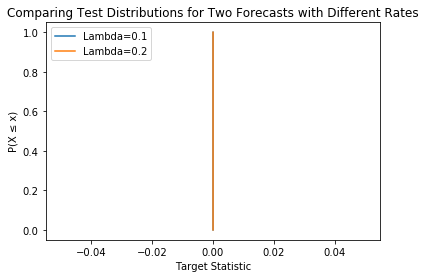

In [5]:
# create dummy region for forecast with origins spanning from 0-9 in both dimensions
origins = np.array(list(itertools.product(np.arange(10), np.arange(10))))
region = CartesianGrid2D.from_origins(origins)

rateA = 0.1
rateB = 0.2

# create uniform spatial forecast
forecastA = create_uniform_spatial_forecast(rateA, region, name=f'Lambda={rateA}')
forecastB = create_uniform_spatial_forecast(rateB, region, name=f'Lambda={rateB}')

# create fake catalog observations, simply as numpy array of counts in cells
n_obs = int(rateA * forecastA.region.num_nodes)
obs_cat = simulate_catalog(forecastA, n_obs)

# compute likelihood with normalization
spatial_stat_no_normA = spatial_test_statistic_no_normalization(forecastA.data, obs_cat.data)
spatial_stat_no_normB = spatial_test_statistic_no_normalization(forecastB.data, obs_cat.data)

# compute likelihood without normalization
spatial_stat_normA = spatial_test_statistic_normalization(forecastA.data, obs_cat.data)
spatial_stat_normB = spatial_test_statistic_normalization(forecastB.data, obs_cat.data)

print("Testing Without Normalization of Forecasted Rates")
print(f"Forecast A (not normalized): {spatial_stat_no_normA}\nForecast B (not normalized): {spatial_stat_no_normB}")
print(f"Log10(K): {np.log10(rateB / rateA)} StatA - StatB: {spatial_stat_no_normB-spatial_stat_no_normA}")
np.testing.assert_allclose(np.log10(rateB/rateA), spatial_stat_no_normB-spatial_stat_no_normA)
print()
print("Testing With Normalization of Forecasted Rates")
print(f"Forecast A (normalized): {spatial_stat_normA}\nForecast B (normalized): {spatial_stat_normB}")
np.testing.assert_allclose(spatial_stat_normA, spatial_stat_normB)

resultA = csep2_spatial_test(forecastA, obs_cat, func=spatial_test_statistic_no_normalization)
resultB = csep2_spatial_test(forecastB, obs_cat, func=spatial_test_statistic_no_normalization)

xA, yA = ecdf(resultA.test_distribution-resultA.observed_statistic)
xB, yB = ecdf(resultB.test_distribution-resultB.observed_statistic)

fig, ax = plt.subplots()
h=ax.plot(xA, yA, label=f'{forecastA.name}')
h=ax.plot(xB, yB, label=f'{forecastB.name}')
h=ax.legend(loc='upper left')
h=ax.set_title('Comparing Test Distributions for Two Forecasts with Different Rates')
h=ax.set_xlabel('Target Statistic')
h=ax.set_ylabel('P(X ≤ x)')
print()
print(f'Quantile Score (ForecastA): {resultA.quantile}\nQuantile Score (ForecastB): {resultB.quantile}')

This numerical experiment shows the necessity of normalizing $\lambda$ in order to compare observed spatial statistics across forecasts. In practice, we are mostly concerned with quantile scores which are unaffected by this normalization. As expected, the difference in the test statistic between the two forecasts is $\log(K)$ where $K$ is the ratio of the forecasted rates.

### Conditioning on the Number of Observed Events for Spatial Test

The proposed statistic represents the geometric mean of the target event rate distribution, therefore not conditioning the simulated number of target events on the observed event counts will produce statistics with different levels of precision. Here, we explore this using the spatially uniform (SU) forecasts from above. We label the distribution 'fixed' if the statistics are computed conditioned on the number of observed events, and 'not fixed' otherwise.

We use two tests that generate families of test statistics through simulation. (1) we condition the number of simulated events on the number of observed events, and (2) we do not condition the number of simulated events on the number of observed events. We will compare quantile scores and variance of the test statistics between these two experiments.

For a spatially uniform forecast (SU), these proposed test statistic should have zero variance with all values being equal to the normalized statistic shown above.

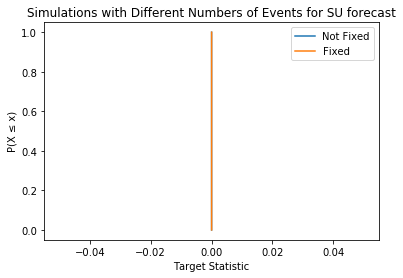

In [6]:
result_fixed = csep2_spatial_test(forecastA, obs_cat, fix_simulated_events=True)
result_not_fixed = csep2_spatial_test(forecastA, obs_cat, fix_simulated_events=False)

xF, yF = ecdf(result_fixed.test_distribution-result_fixed.observed_statistic)
xNF, yNF = ecdf(result_not_fixed.test_distribution-result_not_fixed.observed_statistic)

fig, ax = plt.subplots()
h=ax.plot(xNF, yNF, label='Not Fixed')
h=ax.plot(xF, yF, label='Fixed')
h=ax.legend(loc='upper right')
h=ax.set_title('Simulations with Different Numbers of Events for SU forecast')
h=ax.set_xlabel('Target Statistic')
h=ax.set_ylabel('P(X ≤ x)')

For a SU forecast, conditioning on $N_{obs}$ does not impact the estimate of the test statistic. This behavior should be re-evaluated in the context of a realistic forecast that incorporates spatial variability into the forecast. These results imply that the estimated error of the simulated test statistic is related to the variance of the spatial distribution of the forecast.

### Comparing Poisson and Likelihood-Free Evaluations with Poissonian (CSEP1) Counterparts



The CSEP1 Spatial test is based on Poisson log-likelihood function is defined as, 

\begin{equation}
L(\lambda, \omega) = \omega \log\lambda - \lambda - \log(\omega!).
\end{equation}

Where $\lambda$ represents the expected rates in discrete spatial bins as specified by a forecast and $\omega$ represents observed event counts in the same discrete spatial bins. The $\lambda$ is normalized so its sum equals the number of observed events and events are simulated based on the forecast following Zechar et al., (2010). This statistic represents a joint log-likelihood of $\lambda$ and $\omega$. On the other hand, the CSEP2 spatial-test computes the geometric mean of the target event rate distribution defined as $S$ above. 


Quantile Score (CSEP1): 0.328
Quantile Score (CSEP1): 0.328
Quantile Score (CSEP2): 1.0


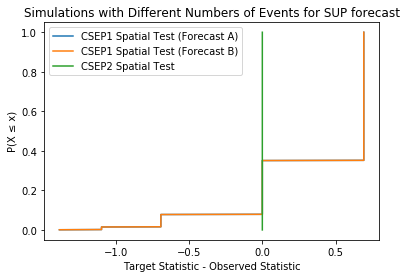

In [7]:
# needed for CSEP1, dummy values and this should chagne in PyCSEP
forecastA.magnitudes = np.arange(10)
forecastB.magnitudes = np.arange(10)
n_sim=1000

# generate random numbers so forecastA == forecastB
random_numbers = np.random.rand(n_sim,n_obs)

csep1_result = csep1_spatial_test(forecastA, obs_cat, verbose=False, random_numbers=random_numbers, num_simulations=n_sim)
csep1_resultB = csep1_spatial_test(forecastB, obs_cat, verbose=False, random_numbers=random_numbers, num_simulations=n_sim)
xC1, yC1 = ecdf(csep1_result.test_distribution-csep1_result.observed_statistic)
xC1B, yC1B = ecdf(csep1_resultB.test_distribution-csep1_result.observed_statistic)
fig, ax = plt.subplots()
h=ax.plot(xC1, yC1, label='CSEP1 Spatial Test (Forecast A)')
h=ax.plot(xC1B, yC1B, label='CSEP1 Spatial Test (Forecast B)')
h=ax.plot(xF, yF, label='CSEP2 Spatial Test')
h=ax.legend(loc='upper left')
h=ax.set_title('Simulations with Different Numbers of Events for SUP forecast')
h=ax.set_xlabel('Target Statistic - Observed Statistic')
h=ax.set_ylabel('P(X ≤ x)')
print()
print(f'Quantile Score (CSEP1): {csep1_result.quantile}\nQuantile Score (CSEP1): {csep1_resultB.quantile}\n' + 
      f'Quantile Score (CSEP2): {result_fixed.quantile}')

The simulated distributions of the test statistics vary between the CSEP1 and CSEP2 implementations of the spatial test, as expected by the differing test statistics. Namely, the CSEP1 test assumes a Poisson distribution for the individual cells which includes additional terms resulting from the discrete assumptions with the Poisson distribution (Rhoades et al., 2011).

The primary difference of these two tests is that the quantile score and test distribution is invariant with the number of simulations assuming a spatially uniform forecast. The CSEP1 metric introduces Poissonian variability and fluctuates both test distribution and quantile score depending on both the observed catalog and simulated likelihood scores.

### Using an approximate Likelihood Statistic instead of Geometric Mean

The proposed metric uses the geometric mean of the target event rate distribution which has the desirable property that two catalogs with identical spatial distributions and different rates will produce identical statistics. We will condition this test on the number of observed events.


Quantile Score (CSEP1): 0.35
Quantile Score (CSEP2 Apprx. LL): 1.0
Quantile Score (CSEP2 Geo. Mean): 1.0
Geo. Mean: -2.0
Apprx. LogLL: -20.0


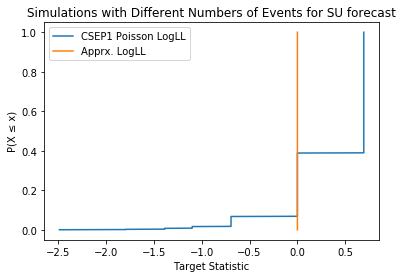

In [13]:
result_fixed_no_mean = csep2_spatial_test(forecastA, obs_cat, fix_simulated_events=True, 
                                  func=approximate_likelihood_statistic_normalization)
csep1_result = csep1_spatial_test(forecastA, obs_cat, verbose=False)

xC1, yC1 = ecdf(csep1_result.test_distribution-csep1_result.observed_statistic)
xF_noMean, yF_noMean = ecdf(result_fixed_no_mean.test_distribution - result_fixed_no_mean.observed_statistic)

fig, ax = plt.subplots()
h=ax.plot(xC1, yC1, label='CSEP1 Poisson LogLL')
h=ax.plot(xF_noMean, yF_noMean, label='Apprx. LogLL')
h=ax.legend(loc='upper left')
h=ax.set_title('Simulations with Different Numbers of Events for SU forecast')
h=ax.set_xlabel('Target Statistic')
h=ax.set_ylabel('P(X ≤ x)')
print()
print(f'Quantile Score (CSEP1): {csep1_result.quantile}\nQuantile Score (CSEP2 Apprx. LL): {result_fixed_no_mean.quantile}\n' +
      f'Quantile Score (CSEP2 Geo. Mean): {result_fixed.quantile}')
print(f'Geo. Mean: {result_fixed.observed_statistic}\nApprx. LogLL: {result_fixed_no_mean.observed_statistic}')

As expected, this modification only changes the value of the observed statistic, but not the overall shape of the simulated test distribution. This behavior will change if we do not fix the number of simulated events to the number of observed events. 

### Approx. Likelihood Statistic with and without Conditioning Simulations on Number of Observed Events

The CSEP2 implementation of the spatial test statistic computes a geometric mean, which negates the impact of the event count in a catalog. Here, we explore how the test distribution looks when calculated as the sum over the log-target event rate distribution as proposed in original document of catalog-based tests.

Quantile Score (CSEP1): 0.32
Quantile Score (CSEP2 Apprx. CondLL; ForecastA): 1.0
Quantile Score (CSEP2 Apprx. LL; ForecastA): 0.5402
Quantile Score (CSEP2 Apprx. LL; ForecastB): 0.9945


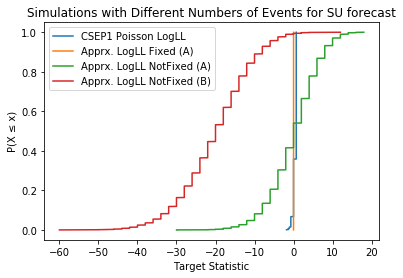

In [9]:
result_fixed_no_mean = csep2_spatial_test(forecastA, obs_cat, fix_simulated_events=True, 
                                  func=approximate_likelihood_statistic_normalization)

result_fixed_no_meanB = csep2_spatial_test(forecastB, obs_cat, fix_simulated_events=True, 
                                  func=approximate_likelihood_statistic_normalization)

# in this case rateA = rate(obs_cat)
result_notfixed_no_mean = csep2_spatial_test(forecastA, obs_cat, fix_simulated_events=False, 
                                  func=approximate_likelihood_statistic_normalization)

# in this case rateB != rate(obs_cat)
result_notfixed_no_meanB = csep2_spatial_test(forecastB, obs_cat, fix_simulated_events=False, 
                                  func=approximate_likelihood_statistic_normalization)

csep1_result = csep1_spatial_test(forecastA, obs_cat, verbose=False)
xC1, yC1 = ecdf(csep1_result.test_distribution-csep1_result.observed_statistic)

xF_noMean, yF_noMean = ecdf(result_fixed_no_mean.test_distribution - result_fixed_no_mean.observed_statistic)
xNF_noMean, yNF_noMean = ecdf(result_notfixed_no_mean.test_distribution - result_notfixed_no_mean.observed_statistic)
xNF_noMeanB, yNF_noMeanB = ecdf(result_notfixed_no_meanB.test_distribution - result_notfixed_no_meanB.observed_statistic)

fig, ax = plt.subplots()
h=ax.plot(xC1, yC1, label='CSEP1 Poisson LogLL')
h=ax.plot(xF_noMean, yF_noMean, label='Apprx. LogLL Fixed (A)')
h=ax.plot(xNF_noMean, yNF_noMean, label='Apprx. LogLL NotFixed (A)')
h=ax.plot(xNF_noMeanB, yNF_noMeanB, label='Apprx. LogLL NotFixed (B)')
h=ax.legend(loc='upper left')
h=ax.set_title('Simulations with Different Numbers of Events for SU forecast')
h=ax.set_xlabel('Target Statistic')
h=ax.set_ylabel('P(X ≤ x)')

print(f'Quantile Score (CSEP1): {csep1_result.quantile}\nQuantile Score (CSEP2 Apprx. CondLL; ForecastA): {result_fixed.quantile}\n' +
      f'Quantile Score (CSEP2 Apprx. LL; ForecastA): {result_notfixed_no_mean.quantile}\nQuantile Score (CSEP2 Apprx. LL; ForecastB): {result_notfixed_no_meanB.quantile}')

The above figure shows four different cases for computing a spatial-test for a SU forecast with associated quantile scores. The blue line denotes the CSEP1 approach that uses a Poisson log-likelihood function. The orange line uses the proposed approach based on the geometric mean of the target event rate distribution. The green line sums builds event rates by summing over the log(event rates) and assuming some non-zero variance in the forecasted number distribution. The expected rate of ForecastA equals the observed number of events. The red line shows the same calculation as prior, but using a forecast, called $B$, with a number distribution containing 2x the number of events.

## Spatial Test Comparisons using UCERF3-ETAS 

[To be completed]

### Cell-wise Approximate Likelihood Ratios between U3ETAS and U3NoFaults

[To be completed]

## Fault-based Ruptures in U3ETAS

[To be completed]

## References

Rhoades, D. A., D. Schorlemmer, M. C. Gerstenberger, A. Christophersen, J. D. Zechar, and M. Imoto (2011). Efficient testing of earthquake forecasting models, Acta Geophys 59 728-747.

Savran, W., M. J. Werner, W. Marzocchi, D. Rhoades, D. D. Jackson, K. R. Milner, E. H. Field, and A. J. Michael (In Prep.). Pseudo-prospective evaluation of UCERF3-ETAS forecasts during the 2019 Ridgecrest Sequence, Bulletin of the Seismological Society of America.

Zechar, J. D., M. C. Gerstenberger, and D. A. Rhoades (2010). Likelihood-Based Tests for Evaluating Space-Rate-Magnitude Earthquake Forecasts, Bulletin of the Seismological Society of America 100 1184-1195.